<a href="https://colab.research.google.com/github/jacopot96/CERN-iCSC-2023-Computing-School/blob/main/Bayesian_Classification_iCSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import sklearn.datasets as datasets

from scipy.stats import entropy

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.random import sample_without_replacement
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp

import matplotlib.pyplot as plt

**Data  Generation**

Two moons dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

In [67]:
# Generate dataset
cent = [[-1, -1], [1, 1]]
Ndata = 1000

X, Y = datasets.make_moons(Ndata, noise=0.20, random_state=16)

# Train-Test split
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.4, random_state=16) 
print(X.shape)

(1000, 2)


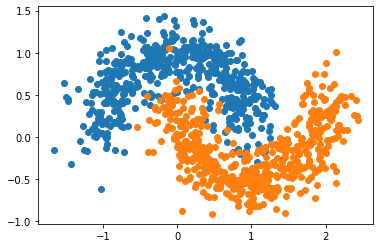

In [68]:
# Draw scatter plot for samples from each class
for class_value in range(2):
	row_ix = np.where(Y == class_value)
	plt.scatter(X[row_ix, 0], X[row_ix, 1])

# MLP Bayes

Implementation based on https://www.tensorflow.org/probability/overview?hl=it
\
Layers based on https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout with Multivariate Normal p.d.f. as priors

In [69]:

# Bayesian MLP based on Variational Inference 

kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_tr.shape[0] *1.0)
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_tr.shape[0] * 1.0)


def model():
  model_vi = Sequential()
  model_vi.add(tfp.layers.DenseFlipout(16, activation = 'relu', bias_prior_fn = tfp.layers.default_multivariate_normal_fn, kernel_divergence_fn = kernel_divergence_fn,bias_divergence_fn=bias_divergence_fn)) 
  model_vi.add(tfp.layers.DenseFlipout(16, activation = 'relu', bias_prior_fn = tfp.layers.default_multivariate_normal_fn, kernel_divergence_fn = kernel_divergence_fn,bias_divergence_fn=bias_divergence_fn))
  model_vi.add(tfp.layers.DenseFlipout(16, activation = 'relu', bias_prior_fn = tfp.layers.default_multivariate_normal_fn, kernel_divergence_fn = kernel_divergence_fn,bias_divergence_fn=bias_divergence_fn))
  model_vi.add(tfp.layers.DenseFlipout(1, activation = 'sigmoid', bias_prior_fn = tfp.layers.default_multivariate_normal_fn, kernel_divergence_fn = kernel_divergence_fn,bias_divergence_fn=bias_divergence_fn))


  model_vi.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])
  return model_vi


### Check of the Priors

Before training the MLP, we can check the predictions on the training set by sampling the parameters of the network from the priors. With reasonable priors we could expect a flat distribution as output. 

In [33]:
#If not, we can try to change the covariance matrix of the gaussian pdf priors, as done for the hyperparameter of the L2 regularization techinque.

In [44]:
model_vi = model()
A = [] #aux for test samples
for i in range(25): #25 forward passes for the same input
  preds = model_vi.predict(X_tr)
  aux = np.array(preds).reshape(len(preds),1)
  aux = np.concatenate((aux, 1-aux), axis = 1)
  A.append(aux)

final = np.mean(np.array(A),axis = 0)
print(final.shape)


ent = entropy(final,axis=1)

19/19 [==============================] - 0s 2ms/step
(600, 2)


Ent of a flat distribution 0.6931471805599453
Mean ent of the data 0.69305867
[[0.49361163 0.50638837]
 [0.4932446  0.5067554 ]
 [0.49397618 0.50602376]
 ...
 [0.49290496 0.50709504]
 [0.49271503 0.50728494]
 [0.49318138 0.5068186 ]]


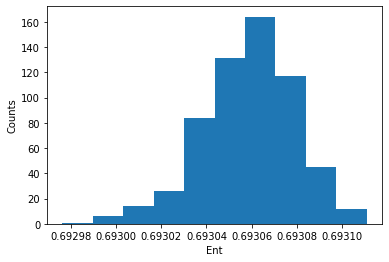

In [45]:
#histogram of the entropies computed on the training set
print('Ent of a flat distribution',entropy([0.5,0.5]))
print('Mean ent of the data',np.mean(ent))
print(final)
plt.hist(ent)
#plt.xlim(0.68,0.693)
plt.ylabel('Counts')
plt.xlabel('Ent');

## Train

In [70]:
model_vi = model()
model_vi.fit(X_tr, y_tr, epochs=160, batch_size=32,validation_data=(X_te, y_te))
model_vi.summary()

Epoch 1/160
19/19 [==============================] - 5s 52ms/step - loss: 3.1219 - accuracy: 0.4967 - val_loss: 3.1111 - val_accuracy: 0.5050
Epoch 2/160
19/19 [==============================] - 0s 9ms/step - loss: 3.1020 - accuracy: 0.4983 - val_loss: 3.0903 - val_accuracy: 0.5050
Epoch 3/160
19/19 [==============================] - 0s 9ms/step - loss: 3.0802 - accuracy: 0.5550 - val_loss: 3.0669 - val_accuracy: 0.6925
Epoch 4/160
19/19 [==============================] - 0s 10ms/step - loss: 3.0513 - accuracy: 0.7383 - val_loss: 3.0320 - val_accuracy: 0.7675
Epoch 5/160
19/19 [==============================] - 0s 11ms/step - loss: 3.0073 - accuracy: 0.7900 - val_loss: 2.9747 - val_accuracy: 0.7900
Epoch 6/160
19/19 [==============================] - 0s 9ms/step - loss: 2.9408 - accuracy: 0.7950 - val_loss: 2.8977 - val_accuracy: 0.8125
Epoch 7/160
19/19 [==============================] - 0s 9ms/step - loss: 2.8536 - accuracy: 0.8100 - val_loss: 2.8126 - val_accuracy: 0.8150
Epoch 8/16

### Test: 25 foward passes for the same input

In [71]:
# definition of a grid in the inputs' space
min1, max1 = X[:, 0].min()-2, X[:, 0].max()+1.5
min2, max2 = X[:, 1].min()-2, X[:, 1].max()+1.5
x1grid = np.arange(min1, max1, 0.05)
x2grid = np.arange(min2, max2, 0.05)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))


In [72]:
A = [] # aux for test samples
B = [] #aux for the grid
ent = []
for i in range(25):
  preds = model_vi.predict(grid)
  A.append(preds)
  B.append(model_vi.predict(X_te))
  aux = np.array(preds).reshape(len(preds),1)
  aux = np.concatenate((aux, 1-aux), axis = 1)
  ent.append(entropy(aux,axis = 1))


final = np.mean(np.array(A),axis=0)
print(final.shape)

zz = final[:,0].reshape(xx.shape)
print(final[0])

predicted_proba_bayes = np.mean(np.array(B),axis=0)

epistemic_uncertainty = np.mean(np.array(ent),axis=0)

13/13 [==============================] - 0s 2ms/step
(17784, 1)
[0.12193493]


In [73]:
fin = np.concatenate((final, 1-final), axis = 1)
print(fin.shape)
predicted_entropy_bayes = entropy(fin,axis = 1)
epistemic_uncertainty = np.mean(np.array(ent),axis = 0)

(17784, 2)


In [74]:
print(predicted_entropy_bayes.shape)
print(epistemic_uncertainty.shape)
print(predicted_entropy_bayes[:2])

(17784,)
(17784,)
[0.3707626  0.17928173]


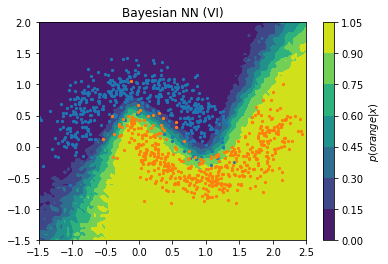

In [75]:
c = plt.contourf(xx, yy, zz)
cbar = plt.colorbar(c)
for class_value in range(2):
	# get row indexes for samples with this class
	row_ix = np.where(Y == class_value)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1],s=5)
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 2)
plt.title('Bayesian NN (VI)')
cbar.set_label('$p(orange| x)$')
#plt.savefig("bayes5.pdf")

# Epistemic-aleatoric decoupling 

In [76]:
from scipy.ndimage.filters import gaussian_filter # for smoothing the plots

<ipython-input-76-48cbfdc7a68a>:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter # for smoothing the plots


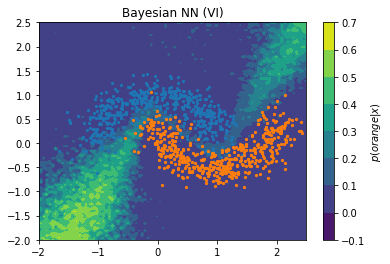

In [77]:
zz_tot_unc = predicted_entropy_bayes.reshape(xx.shape)
zz_al_unc = epistemic_uncertainty.reshape(xx.shape)
zz_ep_unc = zz_tot_unc-zz_al_unc

c = plt.contourf(xx, yy, zz_ep_unc,levels = 7)
cbar = plt.colorbar(c)
for class_value in range(2):
	# get row indexes for samples with this class
	row_ix = np.where(Y == class_value)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1],s=5)
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5)
plt.title('Bayesian NN (VI)')
cbar.set_label('$p(orange| x)$')
#plt.savefig("bayes5.pdf")

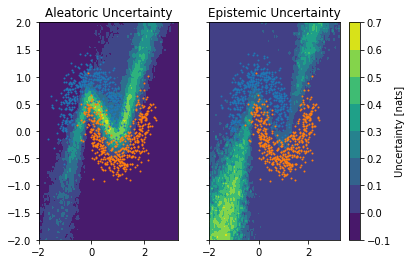

In [78]:
zz_al_uncsmth = gaussian_filter(zz_al_unc, 0.2)
zz_ep_uncsmth = gaussian_filter(zz_ep_unc, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,gridspec_kw={'width_ratios': [0.85, 1]})


ax1.contourf(xx, yy, zz_al_uncsmth,levels=7)
#cbar=plt.colorbar(c)

for class_value in range(2):
	row_ix = np.where(Y == class_value)
	ax1.scatter(X[row_ix, 0], X[row_ix, 1],s=1)

ax1.set_xlim(-2.,3.3)
ax1.set_ylim(-2, 2)
ax1.set_title('Aleatoric Uncertainty')

c = ax2.contourf(xx, yy, zz_ep_uncsmth,levels=7)

for class_value in range(2):
	row_ix = np.where(Y == class_value)
	ax2.scatter(X[row_ix, 0], X[row_ix, 1],s=1)
 
ax2.set_xlim(-2.,3.3)
ax2.set_title('Epistemic Uncertainty')

cbar=plt.colorbar(c)
cbar.set_label('Uncertainty [nats]')
#plt.savefig("dec_unc.pdf")

### Check of the calibration 
https://scikit-learn.org/stable/modules/calibration.html

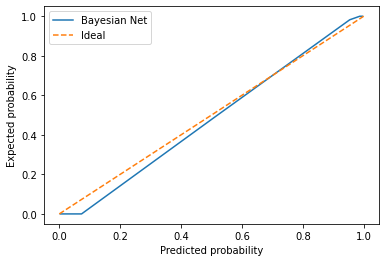

In [79]:
from sklearn.calibration import calibration_curve
prob_true, prob_predicted_bayes = calibration_curve(y_te, predicted_proba_bayes, n_bins=7, strategy="quantile")
plt.plot(prob_predicted_bayes, prob_true, label="Bayesian Net")
plt.plot([0, 1], [0, 1], '--',label="Ideal")
plt.xlabel("Predicted probability")
plt.ylabel("Expected probability")
plt.legend();

# Active Learning
Comparison of Active Learning trough a random acquisition function and Bayesian Active Learng by Disagreement (BALD)


In [80]:
print(X_tr.shape)
print(X_tr[0])

(600, 2)
[ 0.90156266 -0.27917582]


In [81]:
def random_sampling(data,labels,num_batches):
  aux2 = []
  aux3 = []
  num_samples = int((len(data))/num_batches)
  aux = np.arange(len(data))
  random_ind = np.random.choice(aux,size = (num_batches,num_samples),replace = False)
  #print(random_ind)
  for i in range(len(random_ind)):
    aux2.append(data[random_ind[i]])
    aux3.append(labels[random_ind[i]])

  return np.array(aux2),np.array(aux3)

def Information_wise_sampling(data,labels,epistemic,num_samples):
  
  #index= np.argpartition(epistemic, -num_samples)[-num_samples:]
  index = np.argsort(epistemic)[::-1][:num_samples]
  others_index = np.argsort(epistemic)[::-1][num_samples:]
  return data[index],labels[index],data[others_index],labels[others_index]

def testing_epistemic(model,X_te):
  B = []
  ent = []
  for i in range(20):
    preds=model.predict(X_te)
    #print(preds)
    B.append(preds)
    #aux=np.array(B).reshape(len(preds),1)
    aux2 = np.concatenate((preds, 1-preds), axis=1)
    ent.append(entropy(aux2,axis=1))

  predicted_proba_bayes = np.mean(np.array(B),axis=0)
  #print(predicted_proba_bayes)
  epistemic_uncertainty = np.mean(np.array(ent),axis=0)

  return epistemic_uncertainty

In [82]:
random.seed(32)
data_train_ran,labels = random_sampling(X_tr,y_tr,7)
print(data_train_ran.shape)

(7, 85, 2)


## BALD 
The presented approach is based on selecting batches of the most informative points. This strategy can be further improved by noting that we are selecting the most $individually$ informative points withount guarantee that the selected batches of points are also $jointly$ informative (some points may be redundant). See https://arxiv.org/pdf/1906.08158.pdf

In [ ]:
n_experiments = 5             #number of active learning experiments
excluded = 3                  #number of batches to exclude
acc_test_BALD = []
for count in range(n_experiments): 
  first_samples = data_train_ran[0]
  first_samples_labels = labels[0]
  acc_test = np.zeros(len(data_train_ran))
  n_samples = np.zeros(len(data_train_ran))

  for i in range(len(data_train_ran)-excluded):
    if i == 0:
      tr = first_samples
      tr_l = first_samples_labels
      remaining_data = np.concatenate(data_train_ran[1:],axis = 0)
      remaining_data_label = np.concatenate(labels[1:],axis = 0)

    print('experiment',count)
    print('batch',i)
    print('samples train',len(tr))
    model_vi = model()
    model_vi.fit(tr, tr_l, epochs=150, batch_size=16,validation_data = (X_te, y_te),verbose = 0)
    B = []
    n_samples[i] = len(tr)

    for j in range(15):
      B.append(model_vi.predict(X_te,verbose = 0))
    predicted_proba_bayes = np.mean(np.array(B),axis=0)

    acc_test[i] = accuracy_score( y_te,np.array(predicted_proba_bayes+0.5).astype(int))
    test_ep = testing_epistemic(model_vi,remaining_data)
  
    new_tr,new_tr_l,remaining_datan,remaining_data_labeln = Information_wise_sampling(remaining_data,remaining_data_label,test_ep,len(first_samples))
    tr = np.concatenate((tr,new_tr),axis=0)
    tr_l = np.concatenate((tr_l,new_tr_l),axis=0)
    remaining_data = remaining_datan
    remaining_data_label = remaining_data_labeln

  acc_test_BALD.append(acc_test)


In [ ]:
acc_test_BALD

[array([0.9025, 0.9625, 0.98  , 0.98  , 0.    , 0.    , 0.    ]),
 array([0.8775, 0.955 , 0.9775, 0.9775, 0.    , 0.    , 0.    ]),
 array([0.8825, 0.9525, 0.9725, 0.9775, 0.    , 0.    , 0.    ]),
 array([0.885 , 0.97  , 0.9525, 0.9775, 0.    , 0.    , 0.    ]),
 array([0.89  , 0.96  , 0.9775, 0.97  , 0.    , 0.    , 0.    ])]

In [ ]:
np.mean(acc_test_BALD,axis=0)[:-excluded]
np.std(acc_test_BALD,axis=0)[:-excluded]

array([0.00851469, 0.00612372, 0.01004988, 0.00339116])

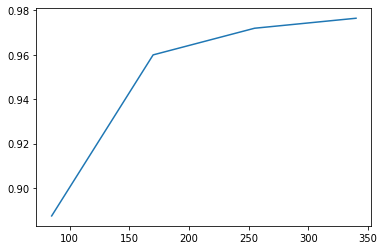

In [ ]:
plt.plot(n_samples[:-excluded],np.mean(acc_test_BALD,axis=0)[:-excluded])

### Random sampling

In [ ]:
Mean_acc_test_r = []
for count in range(n_experiments):
  acc_test_r = np.zeros(len(data_train_ran))
  for i in range(len(data_train_ran)-excluded):
    print('experiment',count)
    labels_tr = labels[:i+1].reshape((i*data_train_ran.shape[1]+data_train_ran.shape[1], 1))
    x_train = np.concatenate(data_train_ran[:i+1],axis = 0)
    print('i',i)
    print('shape',len(labels_tr))
    model_vi = model()
    model_vi.fit(x_train, labels_tr, epochs = 150, batch_size=16,validation_data = (X_te, y_te),verbose = 0)
    B = []
    for j in range(15):
      B.append(model_vi.predict(X_te,verbose = 0))
    predicted_proba_bayes = np.mean(np.array(B),axis = 0)
    acc_test_r[i]=accuracy_score( y_te,np.array(predicted_proba_bayes+0.5).astype(int))
  Mean_acc_test_r.append(acc_test_r)



In [ ]:
Mean_acc_test_r

[array([0.9075, 0.91  , 0.97  , 0.8975, 0.    , 0.    , 0.    ]),
 array([0.89 , 0.89 , 0.97 , 0.955, 0.   , 0.   , 0.   ]),
 array([0.87  , 0.8975, 0.89  , 0.975 , 0.    , 0.    , 0.    ]),
 array([0.905, 0.885, 0.97 , 0.91 , 0.   , 0.   , 0.   ]),
 array([0.8875, 0.8875, 0.9125, 0.9725, 0.    , 0.    , 0.    ])]

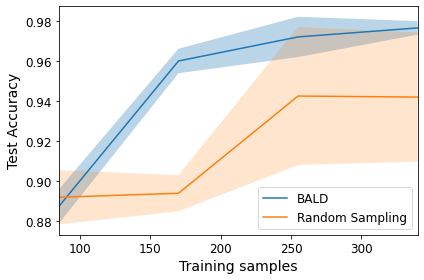

In [ ]:
x = n_samples[:-excluded]
y = np.mean(acc_test_BALD,axis = 0)[:-excluded]
ystd = np.std(acc_test_BALD,axis = 0)[:-excluded]

y2 = np.mean(Mean_acc_test_r,axis = 0)[:-excluded]
y2std = np.std(Mean_acc_test_r,axis = 0)[:-excluded]


fig,ax = plt.subplots()
ax.plot(x, y,label='BALD')
ax.plot(x, y2,label='Random Sampling')

ax.set_xlabel('Training samples',fontsize=14)
ax.set_ylabel('Test Accuracy',fontsize=14)
ax.legend(loc='lower right',fontsize=12)
# create a confidence band of +/- 1std 
y_lower = y-ystd
y_upper = y+ystd

y2_lower = y2-y2std
y2_upper = y2+y2std
ax.set_xlim(85,340)
ax.tick_params(axis='both', labelsize=12)
# plot our confidence band
ax.fill_between(x, y_lower, y_upper, alpha=0.3)
ax.fill_between(x, y2_lower, y2_upper, alpha=0.2)
plt.tight_layout()
#plt.savefig("active_learning.pdf")